In [71]:
import datetime
import json
import os
import sys
import pathlib
from collections import defaultdict
import transformers
from tqdm import tqdm_notebook
from transformers import pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import plotly.express as px
from binance.client import Client
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [56]:
sentiment_analyzer = pipeline('sentiment-analysis')

In [57]:
sentiment_analyzer('I like my cat')

[{'label': 'POSITIVE', 'score': 0.9997277855873108}]

In [58]:
PROJECT_ROOT = pathlib.Path.cwd().parent
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from project_settings import BINANCE_KEY, BINANCE_SECRET

In [59]:
name_mapping = {"Cardano": "ADAUSDT", "Ripple": "XRPUSDT", "Ethereum": "ETHUSDT", "Dogecoin": "DOGEUSDT",
                "Polkadot": "DOTUSDT", "Litecoin": "LTCUSDT", "Solana": "SOLUSDT",
                "VeChain": "VETUSDT", "FileCoin": "FILUSDT", "Monero": "XMRUSDT"}

symbol = "DOTUSDT"

In [64]:
client = Client(BINANCE_KEY, BINANCE_SECRET)
klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, start_str="1 Jan, 2021")
print("History size:", len(klines))

History size: 190


In [65]:
price = []
time = []
volume = []
for c in klines:
    time.append(datetime.datetime.fromtimestamp(int(str(c[0])[:-3])))
    price.append(float(c[4]))
    volume.append(float(c[5]))

hist_prices = pd.DataFrame({"time": time, "price": price, 'volume': volume})
hist_prices.head()

,time,price,volume
0,2021-01-01 02:00:00,0.17509,4.622016e+08
1,2021-01-02 02:00:00,0.17742,6.603033e+08
2,2021-01-03 02:00:00,0.20615,1.201451e+09
3,2021-01-04 02:00:00,0.22528,1.463416e+09
4,2021-01-05 02:00:00,0.25873,1.478888e+09


Text(0.5, 1.0, 'ADAUSDT')

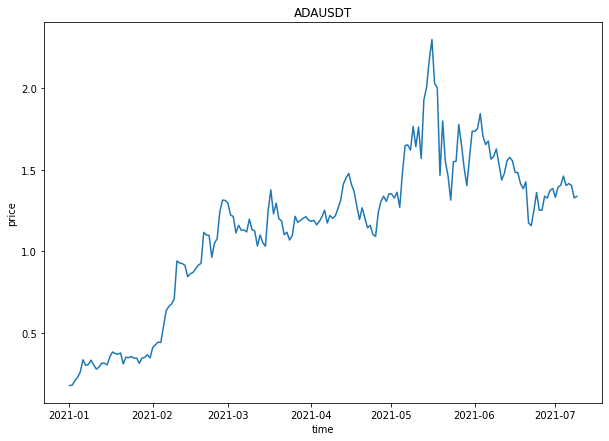

In [66]:
plt.figure(figsize=(10, 7))
sns.lineplot(x=hist_prices["time"], y=hist_prices["price"])
plt.title(symbol)


In [69]:
def aggregate_reddit_data():
    dfs = []
    base_path = PROJECT_ROOT / "reddit_scraper" / "data"
    for file_name in tqdm_notebook(list(os.walk(base_path))[0][2]):
        file_path = str(base_path / f"{file_name}")
        with open(file_path, "r") as f:
            raw_data = json.load(f)
            data = []

            for item in raw_data:
                if type(item) == list:
                    data.extend(item)
                else:
                    data.append(item)

        result = defaultdict(lambda: defaultdict(int))
        sentiment_result = defaultdict(lambda: defaultdict(list))

        for i in data:
            keyword = i["keyword"]
            comments = i["num_comments"]
            if i["type"] == "posts":
                result[keyword]["num_keyword_posts"] += 1
                result[keyword]["num_comments"] += comments
            elif i["type"] == "comments":
                result[keyword]["num_keyword_comments"] += 1
            if i["text"] is not None and len(i["text"]) > 0 and len(i["text"]) < 100:
                sentiment = sentiment_analyzer(i["text"])[0]
                sen_label = sentiment["label"]
                sen_score = sentiment["score"]
                if sen_label == "POSITIVE":
                    sentiment_result[keyword]["pos_sentiment"].append(sen_score)
                elif sen_label == "NEGATIVE":
                    sentiment_result[keyword]["neg_sentiment"].append(sen_score)
                else:
                    raise

        for keyword in sentiment_result.keys():
            for sentiment_type in sentiment_result[keyword]:
                scores = sentiment_result[keyword][sentiment_type]
                mean_score = np.mean(scores) / len(scores)
                result[keyword][sentiment_type] = mean_score

        df = pd.DataFrame(result).T
        df["date"] = file_path.split("_")[-1].split(".")[0]
        dfs.append(df)

    stat_df = pd.concat(dfs).reset_index().rename(columns={"index": "keyword"}).sort_values(["keyword", "date"])
    stat_df = stat_df[["date", "keyword", "num_keyword_posts", "num_comments", "num_keyword_comments", "pos_sentiment",
                       "neg_sentiment"]]
    stat_df.to_csv(PROJECT_ROOT / "reddit_scraper" / "reddit_crypto_stat.csv", index=False)

In [72]:
aggregate_reddit_data()

/tmp/ipykernel_28397/2222763902.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/96 [00:00<?, ?it/s]

In [176]:
def min_max_scale(col):
    return (col - col.min()) / (col.max() - col.min())


def fetch_reddit_data(symbol: str):
    history_data_path = PROJECT_ROOT / "reddit_scraper" / 'reddit_crypto_stat.csv'
    df = pd.read_csv(history_data_path)
    df["keyword"] = df["keyword"].map(name_mapping)
    df = df.set_index(['keyword', 'date'])
    df = df.sort_index()
    sub_df = df.loc[symbol,:].copy()
    sub_df.loc[:,sub_df.columns] = StandardScaler().fit_transform(sub_df)
    sub_df.loc[:,sub_df.columns] = SimpleImputer().fit_transform(sub_df)
    sub_df.index = pd.to_datetime(sub_df.index, yearfirst=True)
    return sub_df

def fetch_search_data(symbol: str):
    df = pd.read_json(PROJECT_ROOT / "search_trends.json")
    df.index = pd.to_datetime(df.index, yearfirst=True)
    df[df.columns] = StandardScaler().fit_transform(df)
    df.columns = list(map(lambda x: name_mapping[x], df.columns))
    sub_df = df[[symbol]]
    sub_df.columns = ["search"]
    return sub_df

In [177]:
hist_reddit = fetch_reddit_data(symbol)
history_prices = hist_prices.set_index("time").loc[hist_reddit.index[0]:]
history_prices[history_prices.columns] = StandardScaler().fit_transform(history_prices)
history_prices.index = history_prices.index.date
history_prices.index.name = "date"
hist_search = fetch_search_data(symbol).loc[hist_reddit.index[0]:]

In [183]:
# fig = px.line(x=history_prices.index, y=history_prices.price, title=symbol)
# fig.add_scatter(x=hist_reddit.index, y=hist_reddit.num_comments.rolling(5, min_periods=1).mean(), name='Comments')
# fig.add_scatter(x=hist_reddit.index, y=hist_reddit.num_keyword_posts.rolling(5, min_periods=1).mean(),
#                 name='Keyword posts')
# fig.add_scatter(x=hist_reddit.index, y=hist_reddit.num_keyword_comments.rolling(5, min_periods=1).mean(),
#                 name='Keyword comments')
# fig.add_scatter(x=hist_reddit.index, y=hist_reddit.neg_sentiment.rolling(5, min_periods=1).mean(),
#                 name="neg senti")
# fig.add_scatter(x=hist_reddit.index, y=hist_reddit.pos_sentiment.rolling(5, min_periods=1).mean(),
#                 name="pos senti")
# fig.add_scatter(x=hist_search.index, y=hist_search[symbol], name="search")
# # fig.add_scatter(x=history_prices.index, y=history_prices.price, name="price")
# fig.show()

In [189]:
px.defaults.width = 1000
px.defaults.height = 600
pd.options.plotting.backend = "plotly"
merge_df = hist_reddit.join(history_prices).join(hist_search)
for col in merge_df.columns:
    merge_df[col] = merge_df[col].rolling(3).mean()
# merge_df = merge_df.reset_index()
merge_df.plot()